In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import bytedtqs
plt.style.use('seaborn-whitegrid')

## Load data from Hive

In [3]:
# sql params
_sql_params = {
    'date': '20200915',
    'DATE': '2020-09-15',
}

In [4]:
# for create table for sample users
sql_0 = """
set spark.sql.adaptive.enabled = true;
set spark.sql.adaptive.join.enabled = true;
set spark.sql.adaptive.hashJoin.enabled = true;
set spark.sql.adaptive.skewedJoin.enabled = true;
set spark.dynamicAllocation.enabled = true;
set spark.dynamicAllocation.maxExecutors = 2000;
set spark.driver.memory = 20g;
set spark.executor.memory = 20g;
set spark.shuffle.hdfs.enabled = true;
set spark.shuffle.io.maxRetries = 1;
set spark.shuffle.io.retryWait = 0s;
set spark.sql.adaptive.maxNumPostShufflePartitions = 5000;
set spark.sql.sources.bucketing.enabled = true;
-- for Hive 0.11.0 through 2.1.x
set hive.groupby.orderby.position.alias=true;
-- allow cartesian
set hive.mapred.mode=nonstrict;
-- allow parallel
set hive.exec.parallel=true;
set hive.exec.parallel.thread.number=8;

create table if not exists dm_eo_test.input_ez_1yr_vip_service_record_sample as 
with vip_services as (
  select
    user_id
    ,vip_days
    ,source_id
    ,from_time
  from dm_ez.vip_operation_record_dict
  where date = '{date}'
    and vip_days = 365
),

orders as (
  select *
  from dm_ez.order_renew_detail
  where date = '{date}'
)

select
  o1.order_id
  ,o1.user_id
  ,to_date(o1.order_create_time) as order_create_date
  ,date_add(o1.raw_expired_date,-365) as service_start_date
  ,o1.raw_expired_date as service_expire_date
  ,min(if(
    o2.order_rank > o1.order_rank 
    and to_date(o2.order_create_time) <= if(
      o1.bonus_vip_days < 0,
      date_add(o1.raw_expired_date,30), 
      date_add(o1.actual_expired_date,30)),
    datediff(to_date(o2.order_create_time),date_add(o1.raw_expired_date,-365)),
    null
  )) as renew_day
from orders as o1
inner join vip_services as vs on o1.order_id = vs.source_id
left join orders as o2 on o1.user_id = o2.user_id
where o1.raw_expired_date between date_add('{DATE}',-270) and  date_add('{DATE}',-60)
group by o1.order_id
  ,o1.user_id
  ,o1.order_create_time
  ,o1.raw_expired_date
limit 30000;
"""

In [5]:
sql_1 = """
select * from dm_eo_test.input_ez_1yr_vip_service_record_sample;
"""

In [6]:
sql_2 = """
set spark.sql.adaptive.enabled = true;
set spark.sql.adaptive.join.enabled = true;
set spark.sql.adaptive.hashJoin.enabled = true;
set spark.sql.adaptive.skewedJoin.enabled = true;
set spark.dynamicAllocation.enabled = true;
set spark.dynamicAllocation.maxExecutors = 2000;
set spark.driver.memory = 20g;
set spark.executor.memory = 20g;
set spark.shuffle.hdfs.enabled = true;
set spark.shuffle.io.maxRetries = 1;
set spark.shuffle.io.retryWait = 0s;
set spark.sql.adaptive.maxNumPostShufflePartitions = 5000;
set spark.sql.sources.bucketing.enabled = true;
-- for Hive 0.11.0 through 2.1.x
set hive.groupby.orderby.position.alias=true;
set hive.mapred.mode=nonstrict;
set hive.exec.parallel=true;
set hive.exec.parallel.thread.number=8;

--------------- SEP ---------------
-- 每日学习时长
with study_duration as (
  select
    user_id
    ,study_date as date
    ,sum(duration) as duration
  from dm_ez.user_study_duration
  where date = '{date}'
  group by 1,2
),

-- 日期维度
date_dimension as (
  select distinct
    concat(substr(date,1,4),'-',substr(date,5,2),'-',substr(date,7,2)) as date
  from origin_db.dim_date
  where year in ('2018','2019','2020')
),

-- 每日学习明细
study_summary as (
  select
    od.user_id
    ,od.order_id
    ,od.service_start_date
    ,od.order_create_date
    ,od.service_expire_date
    ,dd.date as service_date
    ,datediff(dd.date, od.service_start_date) as service_date_diff
    -- ,coalesce(sd.duration,0) as duration
  from dm_eo_test.input_ez_1yr_vip_service_record_sample as od
  -- 笛卡尔积, 列举服务有效期的每一天
  inner join date_dimension as dd
  -- left join study_duration as sd on dd.date = sd.date and o1.user_id = sd.user_id
  -- 日期维度在服务有效期内
  where dd.date between od.service_start_date and od.service_expire_date
    and datediff(dd.date, od.service_start_date) % 30 = 0
)

select
  ss.user_id
  ,ss.order_id
  ,ss.service_start_date
  ,ss.order_create_date
  ,ss.service_expire_date
  ,service_date
  ,service_date_diff
  ,count(if(
    sd.duration > 0 and sd.date between date_add(ss.service_date,-13) and ss.service_date, 
    sd.date, 
    null
  )) as p2w_study_days_00m
  ,count(if(
    sd.duration >= 10*60 and sd.date between date_add(ss.service_date,-13) and ss.service_date, 
    sd.date, 
    null
  )) as p2w_study_days_10m
  ,count(if(
    sd.duration > 0 and sd.date between ss.service_start_date and ss.service_date, 
    sd.date, 
    null
  )) as cum_study_days_00m
  ,count(if(
    sd.duration >= 10*60 and sd.date between ss.service_start_date and ss.service_date, 
    sd.date, 
    null
  )) as cum_study_days_10m
from study_summary as ss
left join study_duration as sd on ss.user_id = sd.user_id
group by 1,2,3,4,5,6,7;
"""

In [ ]:
# tqs params
_app_id, _app_key, _user_name = '', '', ''

# run sql
client = bytedtqs.TQSClient(app_id=_app_id, app_key=_app_key)
job_1 = client.execute_query(user_name=_user_name, query=sql_1.format(**_sql_params))
job_2 = client.execute_query(user_name=_user_name, query=sql_2.format(**_sql_params))
df_1 = pd.read_csv(job_1.get_result().result_url, skiprows=0) # skiprows=2 if hive params set
df_2 = pd.read_csv(job_2.get_result().result_url, skiprows=2) # skiprows=2 if hive params set

## Analysis for individuals

Retention rate v.s. p2w study days.

> retention = study days ≥ 7 in the future

[Text(0, 0.5, ''),
 Text(0.5, 0, 'day # since service start'),
 Text(0.5, 1.0, 'EZ 365 Vip Renew Day Distribution')]

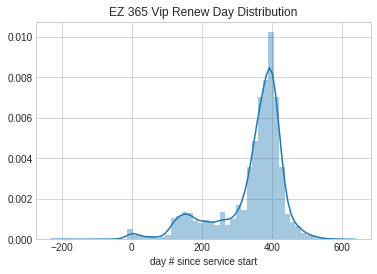

In [8]:
# distribution of renew days
fig, ax = plt.subplots()
ax = sns.distplot(df_1[lambda x: ~x['renew_day'].isna()]['renew_day'])
ax.set(xlabel='day # since service start', ylabel='', title='EZ 365 Vip Renew Day Distribution')

In [9]:
# select cum study days at day 360
all_study_days = df_2[lambda x: x['service_date_diff']==360][['user_id','order_id','cum_study_days_00m','cum_study_days_10m']].\
    rename(columns={'cum_study_days_00m':'all_study_days_00m', 'cum_study_days_10m':'all_study_days_10m'})

# add future study days at each date diff
df_2_exp = pd.merge(df_2, all_study_days, on=['user_id','order_id']).\
    assign(
        future_study_days_00m=lambda x:x['all_study_days_00m']-x['cum_study_days_00m'],
        future_study_days_10m=lambda x:x['all_study_days_10m']-x['cum_study_days_10m'],
    )

# add renew flag
df_2_exp = pd.merge(df_2_exp, df_1[['user_id','order_id','renew_day']], on=['user_id','order_id'])

In [10]:
# add metrics
def agg_custom(x):
    s = {
        'users': x.shape[0],
        'is_active':np.mean(x['future_study_days_10m']>7), 
        'active_days': np.mean(x['future_study_days_10m']),
        'renew_rate': np.mean(x['renew_day']>0),
    }
    return pd.Series(s, index=s.keys())

df_2_exp_10m_agg = df_2_exp.\
    groupby(['service_date_diff', 'p2w_study_days_10m']).\
    apply(agg_custom).reset_index()

# add proportions of users per date_diff
def trans_custom(x):
    x['user_proportion'] = x['users']/sum(x['users'])
    return x

df_2_exp_10m_agg = df_2_exp_10m_agg.\
    groupby(['service_date_diff']).apply(trans_custom).reset_index()

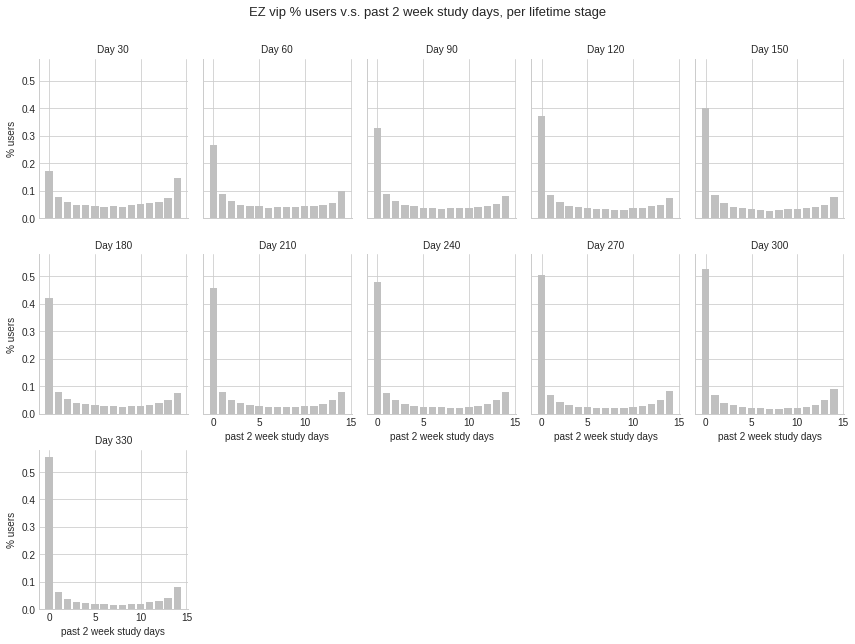

In [64]:
# p2w study day distribution per lifetime stage
g = sns.FacetGrid(
    data=df_2_exp_10m_agg\
        [lambda x: ~x['service_date_diff'].isin([0,360])], 
    col='service_date_diff', 
    col_wrap=5,
    aspect=.8,
)
g.map(plt.bar, 'p2w_study_days_10m', 'user_proportion', color='silver')

g.set_titles(col_template="Day {col_name}")
g.set_axis_labels("past 2 week study days", "% users")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.05)
g.fig.suptitle('EZ vip % users v.s. past 2 week study days, per lifetime stage', fontsize=13)

plt.savefig('./plot_ez_vip_user_distribution_per_p2w_study_days_per_lifetime_stage.png', dpi=200)

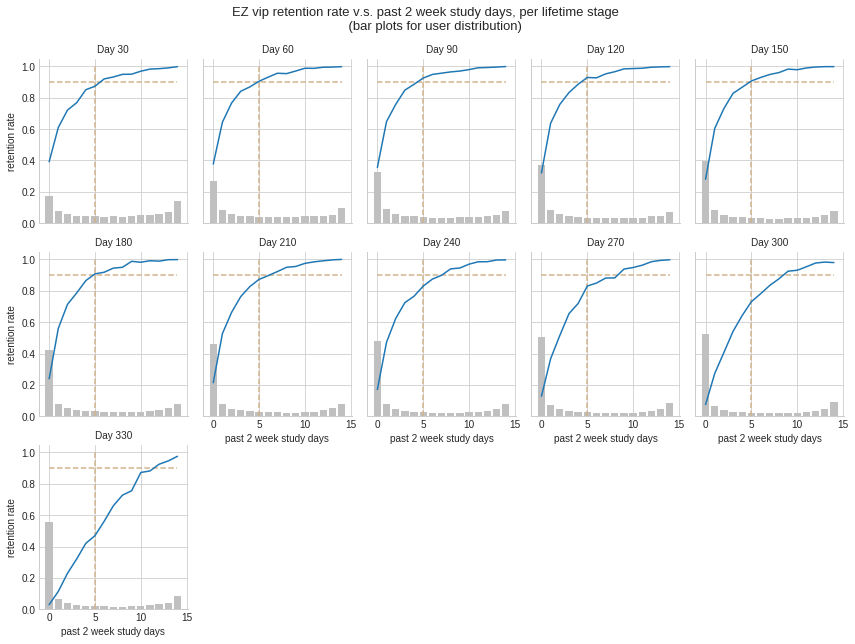

In [20]:
# retention rate v.s. p2w study days
g = sns.FacetGrid(
    data=df_2_exp_10m_agg\
        [lambda x: ~x['service_date_diff'].isin([0,360])], 
    col='service_date_diff', 
    col_wrap=5,
    aspect=.8,
)
g.map(plt.plot, 'p2w_study_days_10m', 'is_active')
g.map(plt.bar, 'p2w_study_days_10m', 'user_proportion', color='silver')

def line_func(*args, **kwargs):
    plt.vlines(x=5, ymin=0, ymax=1, linestyles='dashed', color='tan')
    plt.hlines(y=.9, xmin=0, xmax=14, linestyles='dashed', color='tan')

g.map(line_func)

g.set_titles(col_template="Day {col_name}")
g.set_axis_labels("past 2 week study days", "retention rate")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.05)
g.fig.suptitle('EZ vip retention rate v.s. past 2 week study days, per lifetime stage \n\
    (bar plots for user distribution)', fontsize=13)

plt.savefig('./plot_ez_vip_retention_vs_p2w_study_days_per_lifetime_stage.png', dpi=200)

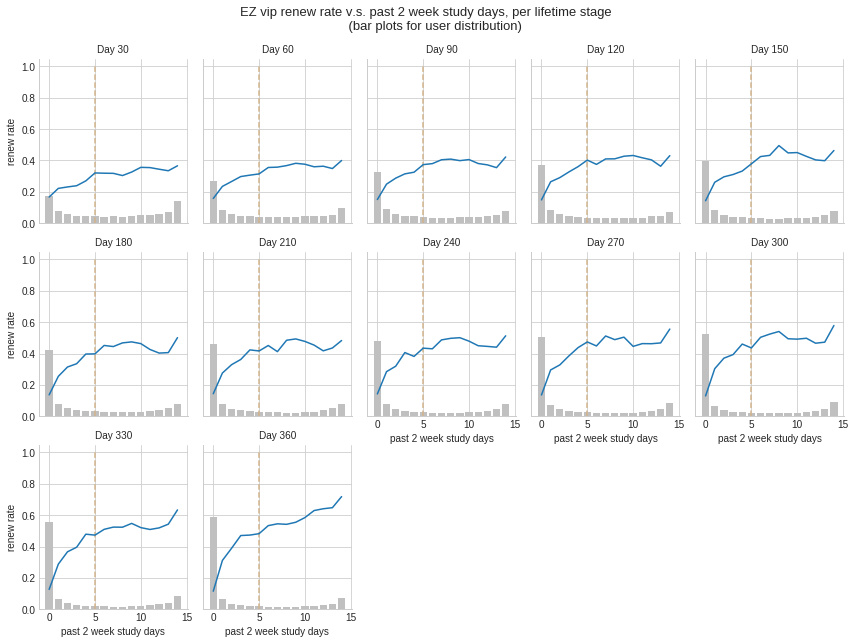

In [73]:
# renew rate v.s. p2w study days
g = sns.FacetGrid(
    data=df_2_exp_10m_agg\
        [lambda x: x['service_date_diff']!=0], 
    col='service_date_diff', 
    col_wrap=5,
    aspect=.8,
)
g.map(plt.plot, 'p2w_study_days_10m', 'renew_rate')
g.map(plt.bar, 'p2w_study_days_10m', 'user_proportion', color='silver')

def line_func(*args, **kwargs):
    plt.vlines(x=5, ymin=0, ymax=1, linestyles='dashed', color='tan')
    

g.map(line_func)
g.set_titles(col_template="Day {col_name}")
g.set_axis_labels("past 2 week study days", "renew rate")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.05)
g.fig.suptitle('EZ vip renew rate v.s. past 2 week study days, per lifetime stage \n\
    (bar plots for user distribution)', fontsize=13)

plt.savefig('./plot_ez_vip_renew_vs_p2w_study_days_per_lifetime_stage.png', dpi=200)

In [11]:
# group by cum study days
df_2_exp_10m_cum_agg = df_2_exp.\
    groupby(['service_date_diff', 'cum_study_days_10m']).\
    apply(agg_custom).reset_index()

# add proportions of users per date_diff
def trans_custom(x):
    x['user_proportion'] = x['users']/sum(x['users'])
    return x

df_2_exp_10m_cum_agg = df_2_exp_10m_cum_agg.\
    groupby(['service_date_diff']).apply(trans_custom).reset_index()

A interesting trend probably related to scholarship campaign. Users whose lifetime study days ≈ 30 turns out to have lower renew rates.

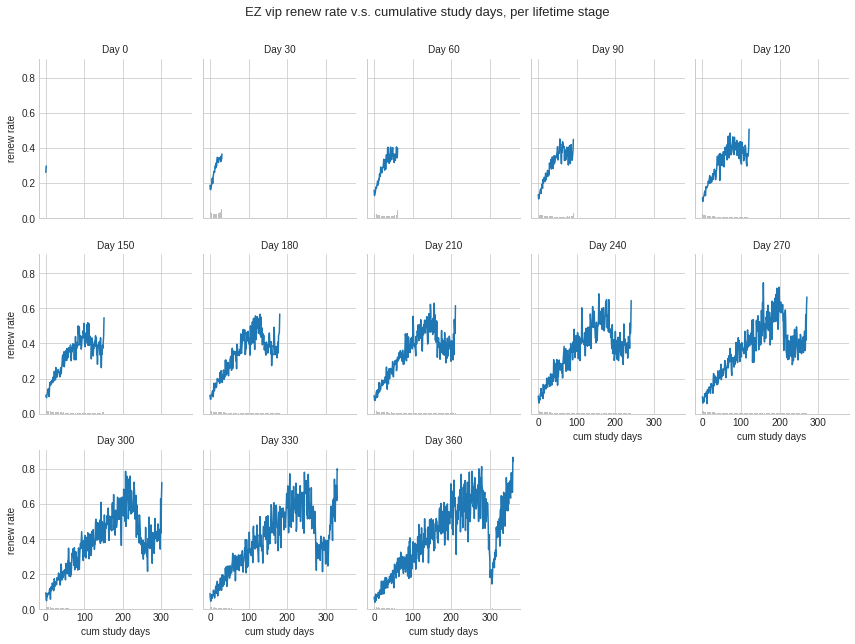

In [72]:
# renew rate v.s. cum study days
g = sns.FacetGrid(
    data=df_2_exp_10m_cum_agg\
        [lambda x: ~x['service_date_diff']!=0], 
    col='service_date_diff', 
    col_wrap=5,
    aspect=.8,
)
g.map(plt.plot, 'cum_study_days_10m', 'renew_rate')
g.map(plt.bar, 'cum_study_days_10m', 'user_proportion', color='silver')

g.set_titles(col_template="Day {col_name}")
g.set_axis_labels("cum study days", "renew rate")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.05)
g.fig.suptitle('EZ vip renew rate v.s. cumulative study days, per lifetime stage', fontsize=13)

plt.savefig('./plot_ez_vip_renew_vs_cum_study_days_per_lifetime_stage.png', dpi=200)

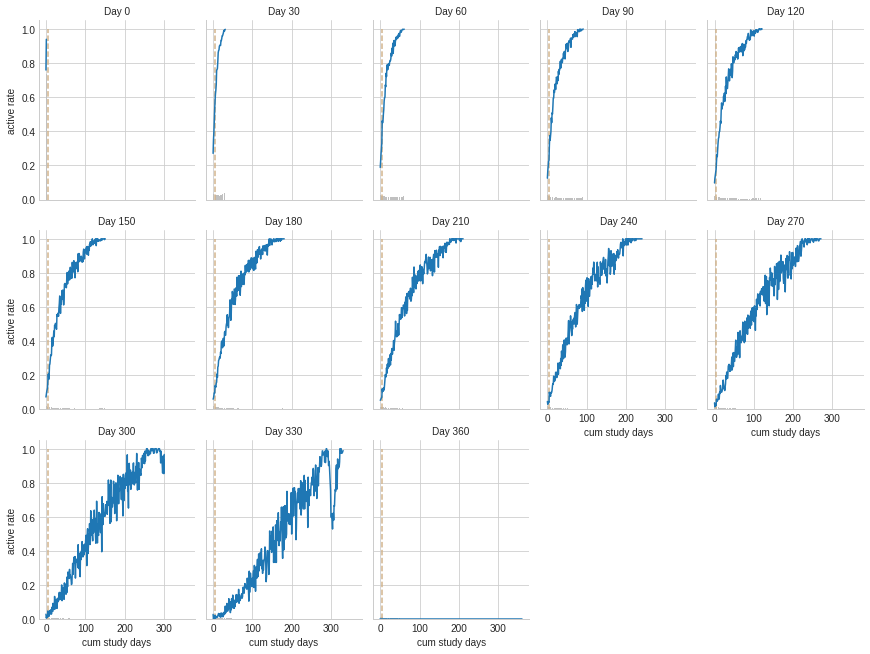

In [24]:
# retention rate v.s. cum study days
g = sns.FacetGrid(
    data=df_2_exp_10m_cum_agg\
        [lambda x: ~x['service_date_diff']!=0], 
    col='service_date_diff', 
    col_wrap=5,
    aspect=.8,
)
g.map(plt.plot, 'cum_study_days_10m', 'is_active')
g.map(plt.bar, 'cum_study_days_10m', 'user_proportion', color='silver')

def line_func(*args, **kwargs):
    plt.vlines(x=5, ymin=0, ymax=1, linestyles='dashed', color='tan')
    
g.map(line_func)
g.set_titles(col_template="Day {col_name}")
g.set_axis_labels("cum study days", "active rate")

## Correlation nalysis for group metrics

p2w-5day rates are correlated across different lifetime stages, which requires consistent service to VIP users.

In [12]:
# add random group_id for correlation analysis
# IMPORTANT!!!
N_GROUPS = 300

order_ids = df_2_exp['order_id'].unique()
group_ids = np.random.permutation(np.arange(0, len(order_ids))) % N_GROUPS
map_order_id_index = {x: y for x, y in zip(order_ids, group_ids)}
df_2_exp['group_id'] = df_2_exp['order_id'].map(map_order_id_index)

In [13]:
# get ratio of active users by group_id
def agg_act_rate(x):
    s = {
        'rate_5_days': np.mean(x['p2w_study_days_10m']>=5),
        'mean_days': np.mean(x['p2w_study_days_10m']),
        'renew_rate': np.mean(x['renew_day']>0),
    }
    return pd.Series(s, index=s.keys())  

df_2_exp_10m_act_agg = df_2_exp[lambda x: x['service_date_diff']!=0].\
    groupby(['group_id','service_date_diff']).apply(agg_act_rate).reset_index()

In [14]:
# add str column for date diff
df_2_exp_10m_act_agg['diff_str'] = ('000' + df_2_exp_10m_act_agg['service_date_diff'].astype(str)).str.slice(-3)

In [15]:
# select columns and rename for correlation matrices
df_2_act_rate_long = df_2_exp_10m_act_agg[['group_id','rate_5_days','diff_str']].rename(columns={'rate_5_days':'value'})
corr_2_act_rate = df_2_act_rate_long.set_index(['group_id','diff_str']).unstack(1).corr()

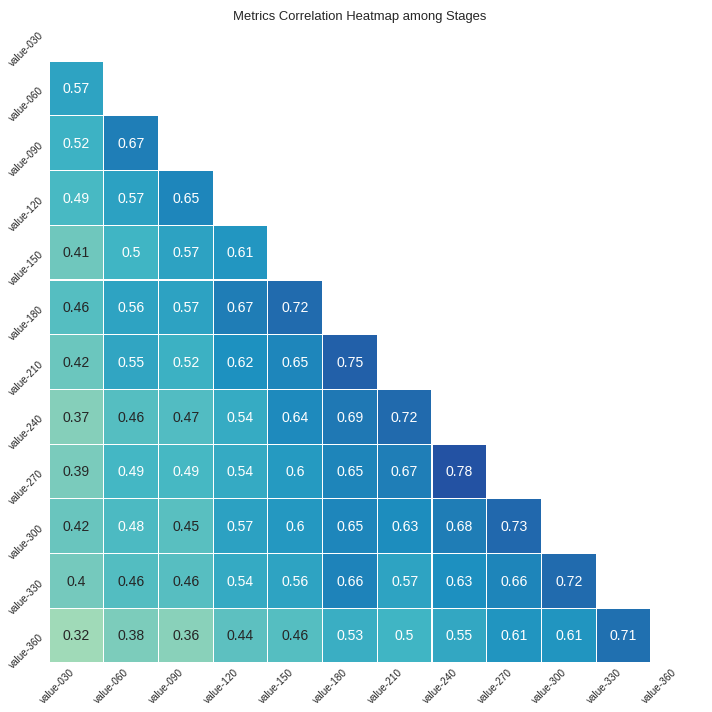

In [61]:
# correlation heatmap
mask = np.zeros_like(corr_2_act_rate)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    corr_2_act_rate, 
    vmin=0, vmax=1,
    square=True,
    cmap="YlGnBu",
    cbar=False,
    annot=True,
    annot_kws={'fontsize':14},
    linewidths=.2,
    mask=mask,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("")
ax.set_ylabel("")
fig.suptitle("Metrics Correlation Heatmap among Stages", fontsize=13)
plt.tight_layout()
plt.savefig('./plot_correlation_among_different_stage.png', dpi=200)

## Threshold design

In [16]:
df_2_exp['service_expire_month'] = pd.to_datetime(df_2_exp['service_expire_date']).dt.to_period('M')

In [17]:
df_2_exp_rate_by_diff_month = df_2_exp[lambda x: x['service_date_diff']!=0].\
    groupby(['service_date_diff','service_expire_month']).apply(agg_act_rate).reset_index()

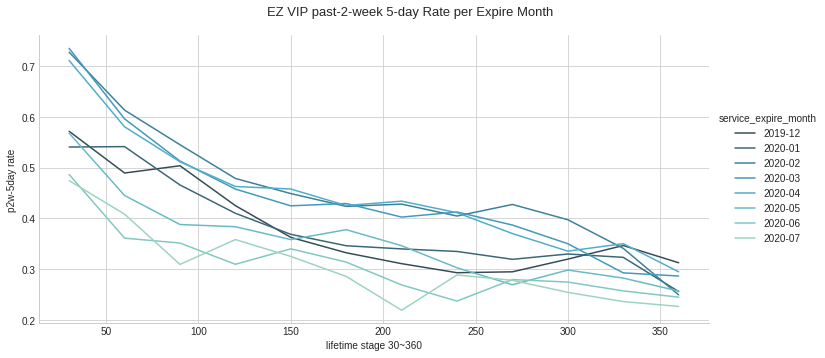

In [100]:
g = sns.FacetGrid(data=df_2_exp_rate_by_diff_month, hue='service_expire_month', palette='GnBu_d')
g.map(plt.plot, 'service_date_diff', 'rate_5_days')
g.fig.set_size_inches(10, 5)
g.add_legend()
g.set_axis_labels("lifetime stage 30~360", "p2w-5day rate")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.1)
g.fig.suptitle('EZ VIP past-2-week 5-day Rate per Expire Month', fontsize=13)

plt.savefig('./plot_ez_vip_p2w_5d_rate_vs_lifetime_stage_per_expire.png', dpi=200)

In [32]:
# p2w-5day rate and renew rate per expire date per lifetime stage
df_2_exp_rate_by_diff_expire = df_2_exp.groupby(['service_expire_date','service_expire_month','service_date_diff']).apply(agg_act_rate).reset_index()

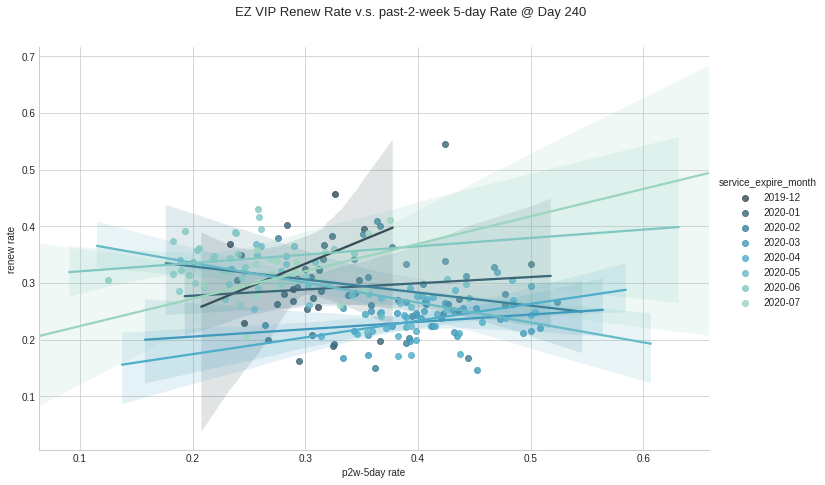

In [44]:
# positive correlation of renew rate v.s. p2w-5day rate per expire month
g = sns.FacetGrid(
    data=df_2_exp_rate_by_diff_expire[lambda x: x['service_date_diff']==240],
    hue='service_expire_month',
    palette='GnBu_d'
)
g.map(sns.regplot, 'rate_5_days', 'renew_rate', ci=97)
g.fig.set_size_inches(10, 7)
g.add_legend()
g.set_axis_labels("p2w-5day rate", "renew rate")
g.fig.subplots_adjust(top=.9, left=.05, bottom=.1)
g.fig.suptitle('EZ VIP Renew Rate v.s. past-2-week 5-day Rate @ Day 240', fontsize=13)

plt.savefig('./plot_ez_vip_renew_rate_vs_p2w_5d_rate.png', dpi=200)

In [74]:
# add group column according to study_days_10m
df_2_exp['days_ge_5'] = (df_2_exp['p2w_study_days_10m'] >= 5)

In [77]:
def agg_renew_split(x):
    s = {
        'users': x.shape[0],
        'renew_rate': np.mean(x['renew_day']>0),
    }
    return pd.Series(s, index=s.keys())

df_2_exp.groupby(['service_date_diff','days_ge_5']).apply(agg_renew_split).reset_index()

,service_date_diff,days_ge_5,users,renew_rate
0,0,False,11084.0,0.261999
1,0,True,18922.0,0.301607
2,30,False,12050.0,0.207137
3,30,True,17956.0,0.340555
4,60,False,15269.0,0.210361
5,60,True,14737.0,0.366357
6,90,False,17054.0,0.207576
7,90,True,12952.0,0.391523
8,120,False,17982.0,0.206262
9,120,True,12024.0,0.407685
